In [1]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = self.softmax(energy)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out


In [2]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                       nn.BatchNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                       nn.BatchNorm2d(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(Generator, self).__init__()
        
        model = [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3),
                 nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]
        
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.BatchNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        # Resnet blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        # Self-Attention Layer
        model += [SelfAttention(ngf * mult)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1),
                      nn.BatchNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        
        model += [nn.Conv2d(ngf, output_nc, kernel_size=3,stride=1,padding=1),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


In [3]:
s=Generator(3,3)
x=torch.rand(5,3,256,256)
k=s(x)
print(k.shape)

torch.Size([5, 3, 256, 256])


In [4]:
from torch.nn import functional as F
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)
        )
        self.fc1 = nn.Linear(30*30,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, input):
        x= self.model(input)
        x=x.view(x.size(0), -1)
        out = self.leaky_relu(self.fc1(x))
        out = self.fc2(out)
        return F.sigmoid(out)



In [5]:
d=Discriminator(3)
z=d(k)
z.shape

torch.Size([5, 1])

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
from tqdm import tqdm
from math import inf
from PIL import Image
import glob
import os
import numpy as np
from torchvision.transforms import ToTensor
device ='cuda:1' if torch.cuda.is_available() else 'cpu'
class MRIDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, transform=None):
        self.low_res_paths = sorted(glob.glob(low_res_dir + '/*.png'))
        self.high_res_paths = sorted(glob.glob(high_res_dir + '/*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.low_res_paths)

    def __getitem__(self, idx):
        low_res_image = Image.open(self.low_res_paths[idx]).convert('RGB')
        high_res_image = Image.open(self.high_res_paths[idx]).convert('RGB')

        if self.transform:
            low_res_image = self.transform(low_res_image)
            # print(low_res_image.shape)
            high_res_image = self.transform(high_res_image)

        return low_res_image, high_res_image

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset =MRIDataset(low_res_dir=r'/home/shivang/mic/micdata/lowresdata', high_res_dir=r'/home/shivang/mic/micdata/highresdata', transform=transform)
train_size=int(len(dataset)*0.9)
val_size=len(dataset)-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
print(len(train_dataloader))

G_A2B = Generator(3, 3).to(device)
G_B2A = Generator(3, 3).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 100
g_best = float(inf)
d_best = float(inf)




3990


In [7]:
load=True
if (load):
    checkpointgen1 = torch.load('/home/shivang/mic/G_A2B_best.pth')
    checkpointdis1 = torch.load('/home/shivang/mic/D_A_best.pth')
    checkpointgen2 = torch.load('/home/shivang/mic/G_B2A_best.pth')
    checkpointdis2 = torch.load('/home/shivang/mic/D_B_best.pth')
    # print(checkpointgen.keys())
    G_A2B.load_state_dict(checkpointgen1)
    G_B2A.load_state_dict(checkpointgen2)
    D_A.load_state_dict(checkpointdis1)
    D_B.load_state_dict(checkpointdis2)


/tmp/ipykernel_891502/1527206293.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpointgen1 = torch.load('/home/shivang/mic/G_A2B_best.pth')
/tmp/ipykernel_891502/15

In [126]:
for epoch in range(num_epochs):
    total_g_loss = 0.0
    total_d_loss_A = 0.0
    total_d_loss_B = 0.0
    num_batches = len(train_dataloader)

    for i, (real_A, real_B) in tqdm(enumerate(train_dataloader), total=num_batches):
        real_A, real_B = real_A.to(device), real_B.to(device)
        valid = torch.ones((real_A.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((real_A.size(0), 1), requires_grad=False).to(device)

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_B2A(real_A), real_A)
        loss_id_B = criterion_identity(G_A2B(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)

        fake_A = G_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

        # Cycle loss
        recov_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)

        recov_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss for Generator
        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity
        loss_G.backward()
        optimizer_G.step()

        # Accumulate generator loss
        total_g_loss += loss_G.item()

        # ----------------------
        #  Train Discriminator A
        # ----------------------
        optimizer_D_A.zero_grad()

        loss_real_A = criterion_GAN(D_A(real_A), valid)
        loss_fake_A = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real_A + loss_fake_A) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        # Accumulate discriminator A loss
        total_d_loss_A += loss_D_A.item()

        # ----------------------
        #  Train Discriminator B
        # ----------------------
        optimizer_D_B.zero_grad()

        loss_real_B = criterion_GAN(D_B(real_B), valid)
        loss_fake_B = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real_B + loss_fake_B) / 2
        loss_D_B.backward()
        optimizer_D_B.step()

        # Accumulate discriminator B loss
        total_d_loss_B += loss_D_B.item()

    # Calculate average losses over the epoch
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss_A = total_d_loss_A / num_batches
    avg_d_loss_B = total_d_loss_B / num_batches
    avg_d_loss = (avg_d_loss_A + avg_d_loss_B) / 2

    # Save Best Models Based on Average Losses
    if avg_g_loss < g_best:
        g_best = avg_g_loss
        torch.save(G_A2B.state_dict(), 'G_A2B_best.pth')
        torch.save(G_B2A.state_dict(), 'G_B2A_best.pth')
        print(f"Epoch {epoch}: Saved new best generator model with Avg G Loss: {g_best}")

    if avg_d_loss < d_best:
        d_best = avg_d_loss
        torch.save(D_A.state_dict(), 'D_A_best.pth')
        torch.save(D_B.state_dict(), 'D_B_best.pth')
        print(f"Epoch {epoch}: Saved new best discriminator model with Avg D Loss: {d_best}")

    # Print the average losses for this epoch
    print(f"Epoch {epoch}/{num_epochs} | Avg G Loss: {avg_g_loss} | Avg D Loss: {avg_d_loss}")


 78%|███████▊  | 3114/3990 [40:27<11:16,  1.29it/s]

In [8]:

import matplotlib.pyplot as plt
def plot_sample_images(low_res, high_res, generated):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(low_res[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Low Resolution')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(generated[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title('Generated')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(high_res[0].permute(1, 2, 0).cpu().numpy())
    plt.title('High Resolution')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(img1,img2):
    # print(img1.shape,img2.shape)
    ssim_values = []
    for i in range(3):  # Loop through each color channel
        ssim_value, _ = ssim(img1[i,...], img2[i,...], full=True,data_range=255.0)
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

100%|██████████| 1773/1773 [01:15<00:00, 23.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average PSNR: 32.27072259513168
Average Low PSNR: 27.650581939471987
Average SSIM: 0.9999612085587707
Average Low SSIM: 0.9997783646989495


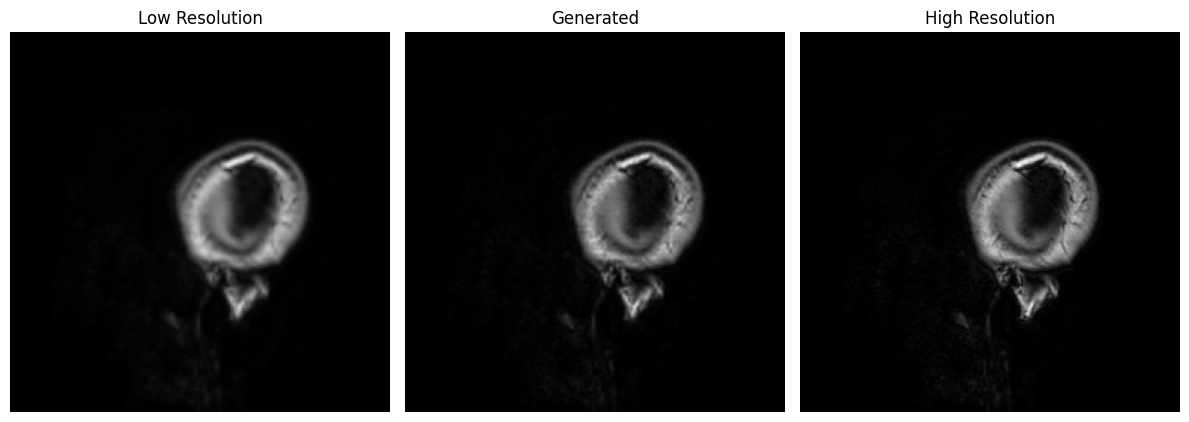

32.27072259513168

In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr


def evaluate_model(generator, test_loader):
    generator.eval()
    psnr_values = []
    low_psnr=[]
    ssim_values=[]
    low_ssim=[]

    with torch.no_grad():
        for low_res, high_res in tqdm(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            gen_high_res = generator(low_res)
            psnr_value = psnr(high_res.cpu().numpy(), gen_high_res.cpu().detach().numpy())
            ssim_value=calculate_ssim(high_res.cpu().numpy()[0], gen_high_res.cpu().detach().numpy()[0])
            low_ps=psnr(high_res.cpu().numpy(), low_res.cpu().numpy())
            low_ss=calculate_ssim(high_res.cpu().numpy()[0], low_res.cpu().numpy()[0])
            low_psnr.append(low_ps)
            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)
            low_ssim.append(low_ss)
    avg_low_psnr = np.mean(low_psnr)
    avg_psnr = np.mean(psnr_values)
    avg_ssim=np.mean(ssim_values)
    avg_low_ssim=np.mean(low_ssim)
    print(f'Average PSNR: {avg_psnr}')
    print(f'Average Low PSNR: {avg_low_psnr}')
    print(f'Average SSIM:',avg_ssim)
    print(f'Average Low SSIM:',avg_low_ssim)
    plot_sample_images(low_res, high_res, gen_high_res)
    return avg_psnr



evaluate_model(G_A2B, val_dataloader)

100%|██████████| 444/444 [00:25<00:00, 17.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average PSNR: 32.06659240764503


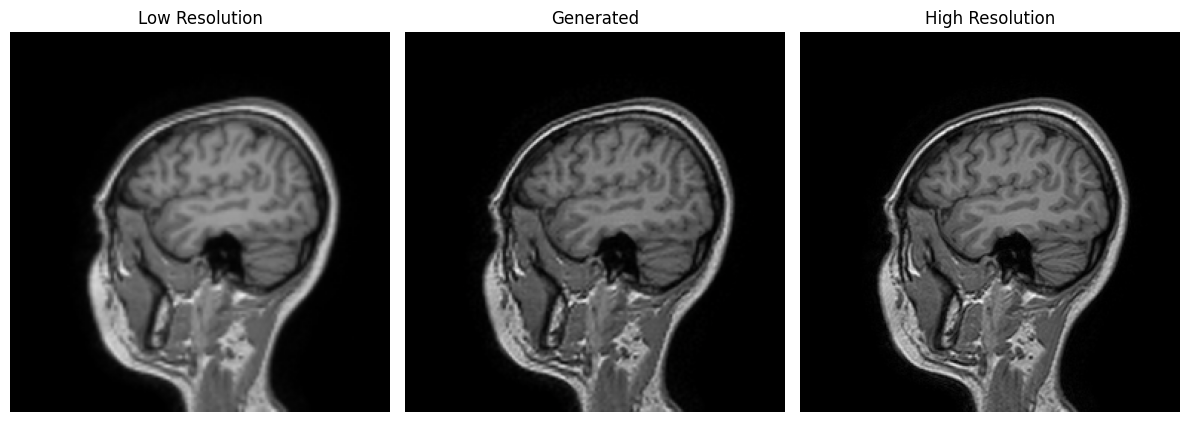

32.06659240764503

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
def evaluate_model(generator, test_loader):
    generator.eval()
    psnr_values = []

    with torch.no_grad():
        for low_res, high_res in tqdm(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            gen_high_res = generator(low_res)
            psnr_value = psnr(high_res.cpu().numpy(), gen_high_res.cpu().detach().numpy())
            psnr_values.append(psnr_value)

    avg_psnr = np.mean(psnr_values)
    print(f'Average PSNR: {avg_psnr}')
    plot_sample_images(low_res, high_res, gen_high_res)
    return avg_psnr



evaluate_model(G_A2B, val_dataloader)

In [ ]:
# from skimage.metrics import peak_signal_noise_ratio as psnr
# def evaluate_model(generator, test_loader):
#     generator.eval()
#     psnr_values = []

#     with torch.no_grad():
#         for low_res, high_res in tqdm(test_loader):
#             low_res = low_res.to(device)
#             high_res = high_res.to(device)

#             gen_high_res = generator(low_res)
#             gen_high_res.cpu().detach().numpy()
#             psnr_values.append(psnr_value)

# evaluate_model(G_A2B, val_dataloader)

In [81]:
def save_image(image_array, filename):
    # If the image is in the range 0-1, scale it to 0-255
    if image_array.max() <= 1.0:
        image_array = (image_array * 255).astype(np.uint8)
    
    # Save using Matplotlib's imsave
    plt.imsave(filename, image_array, cmap='gray' if image_array.ndim == 2 else None)

In [13]:
import glob
import numpy as np
from PIL import Image
import torch
import PIL.Image as pil_image
import os
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, PeakSignalNoiseRatioWithBlockedEffect
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatioWithBlockedEffect
from torchvision.transforms.functional import to_tensor, to_grayscale
from torchmetrics.functional import multiscale_structural_similarity_index_measure
import matplotlib.pyplot as plt
import lpips

import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor

import argparse

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
GPU=1
DIR='/home/shivang/mic/saved_output'

# import lpips

from torchmetrics.functional import multiscale_structural_similarity_index_measure as ms_ssim

def calculate_ms_ssim(list1, list2):
    c = list1[0].shape[2]
    aggregate_loss = 0.0
    for img1, img2 in zip(list1, list2):
        ms_ssim_values = []
        for i in range(c):  # Loop through each color channel
            tensor1 = torch.tensor(img1[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            tensor2 = torch.tensor(img2[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            ms_ssim_value = ms_ssim(tensor1, tensor2).item()
            ms_ssim_values.append(ms_ssim_value)
        aggregate_loss += np.mean(ms_ssim_values)
    return aggregate_loss / len(list1)

def calculate_mse(list1, list2):
    aggregated_loss = 0.0
    for high_quality_frame, predicted_frame in zip(list1, list2):
        loss = mean_squared_error(high_quality_frame, predicted_frame)
        aggregated_loss += loss
    return aggregated_loss / len(list1)

def calculate_psnr_b(list1, list2):
    c = list1[0].shape[2]
    psnr_b=PeakSignalNoiseRatioWithBlockedEffect()
    aggregate_loss = 0.0
    for img1, img2 in zip(list1, list2):
        psnr_b_values = []
        for i in range(c):  # Loop through each color channel
            tensor1 = torch.tensor(img1[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            tensor2 = torch.tensor(img2[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            psnr_b_value = psnr_b(tensor1, tensor2).item()
            psnr_b_values.append(psnr_b_value)
        aggregate_loss += np.mean(psnr_b_values)
    return aggregate_loss / len(list1)

def calculate_psnr(list1, list2):
    c=list1[0].shape[2]
    aggregate_loss=0.0
    for img1,img2 in zip(list1,list2):
        psnr_values = []
        for i in range(c):  # Loop through each color channel
            mse = np.mean((img1[..., i] - img2[..., i]) ** 2)
            if mse == 0:
                psnr_values.append(float('inf'))
            else:
                PIXEL_MAX = 255.0
                psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
                psnr_values.append(psnr)

        aggregate_loss+=np.mean(psnr_values)
    return aggregate_loss/len(list1)

def calculate_ssim(list1, list2):
    c=list1[0].shape[2]
    aggregate_loss=0.0
    for img1,img2 in zip(list1,list2):
        ssim_values = []
        for i in range(c):  # Loop through each color channel
            ssim_value, _ = ssim(img1[..., i], img2[..., i], full=True,data_range=255.0)
            ssim_values.append(ssim_value)
        aggregate_loss+=np.mean(ssim_values)
    return aggregate_loss/len(list1)

def predict(model, low_res):
    device = torch.device(f"cuda:{GPU}")
    low_res=low_res.to(device)
    # model.eval()
    # Perform prediction
    with torch.no_grad():
        pred_res = model(low_res)
    

    # Convert predicted patch to numpy and store in list
    pred_res = pred_res.squeeze(0).permute(1,2,0).cpu().detach().numpy()

    # Reconstruct frames from predicted patches
    # print(reconstructed_frame)
    pred_res = np.clip(pred_res * 255, 0, 255).astype(np.uint8)
    # print(result_frame.std(),result_frame.max())
    return pred_res

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def compute_fid(real_images, fake_images):
    device = torch.device(f"cuda:{GPU}")
    fid_metric = FrechetInceptionDistance().to(device)
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_score = fid_metric.compute()
    return fid_score

def load_image(image):
    if isinstance(image, np.ndarray):  # If the input is a NumPy array
        image = Image.fromarray(image).convert("RGB")
    # Resize to Inception v3 input size
    image = image.resize((299, 299))
    # Convert to tensor and scale to [0, 255]
    image_tensor = to_tensor(image).mul(255).to(torch.uint8)
    device = torch.device(f"cuda:{GPU}")
    return image_tensor.to(device)


def rgb_to_grayscale(rgb_image):
    # Convert NumPy array to PIL Image
    pil_image = Image.fromarray(np.uint8(rgb_image))
    
    # Convert PIL Image to grayscale
    grayscale_pil_image = pil_image.convert('L')
    
    # Convert grayscale PIL Image back to NumPy array
    grayscale_np_image = np.array(grayscale_pil_image)
    
    return grayscale_np_image

def test(model,val_dataloader):
    device = torch.device(f"cuda:{GPU}")
    

    psnr_values_compressed, ssim_values_compressed, psnr_b_values_compressed = [], [], []
    psnr_values_output, ssim_values_output, psnr_b_values_output = [], [], []
    pl_values_compressed, pl_values_output = [], []
    ms_ssim_values_compressed, ms_ssim_values_output = [], []
    original_images = []
    compressed_images = []
    model_output_images = []

    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_b_metric = PeakSignalNoiseRatioWithBlockedEffect().to(device)
    lpips_metric = lpips.LPIPS(net='vgg').to(device)
    i=0
    for low_res,high_res in val_dataloader:
        
        
        predicted_frame=predict(model,low_res)
        # predicted_frame=predicted_frame.squeeze()
        # print(predicted_frame.shape,predicted_frame.std(),predicted_frame.max())
        predicted_img = pil_image.fromarray(predicted_frame, mode='RGB')
        low_res=low_res.squeeze(0).permute(1,2,0).numpy()
        high_res=high_res.squeeze(0).permute(1,2,0).numpy()
        directory=DIR+'/images'
        if not os.path.exists(directory):
            os.mkdir(directory)
        output_path=directory+"/"+str(i)+'.png'
        predicted_img.save(output_path)
        if high_res.ndim == 2:  # If it's a grayscale image with shape (height, width)
            high_res = np.stack([high_res] * 3, axis=-1)  # Convert to (height, width, 3)
        elif high_res.shape[0] == 1 or high_res.shape[1] == 1:
            high_res = np.squeeze(high_res)  # Remove the single dimension if necessary

        # Convert the array to uint8
        high_res_uint8 = (high_res * 255).astype(np.uint8)  # Assuming the array is normalized between 0 and 1

        # Convert to PIL Image
        original_img = Image.fromarray(high_res_uint8).convert("RGB")
        if low_res.ndim == 2:  # If it's a grayscale image with shape (height, width)
            low_res = np.stack([low_res] * 3, axis=-1)  # Convert to (height, width, 3)
        elif low_res.shape[0] == 1 or low_res.shape[1] == 1:
            low_res = np.squeeze(low_res)  # Remove the single dimension if necessary

        # Convert the low-resolution array to uint8
        low_res_uint8 = (low_res * 255).astype(np.uint8)  # Assuming the array is normalized between 0 and 1

        # Convert low-resolution array to PIL Image
        compressed_img = Image.fromarray(low_res_uint8).convert("RGB")
        # original_img = Image.fromarray(high_res).convert("RGB")
        # compressed_img=Image.fromarray(low_res).convert("RGB")
        # print(compressed_img.size,original_img.size)
        original_images.append(load_image(high_res_uint8))
        compressed_images.append(load_image(low_res_uint8))
        model_output_images.append(load_image(predicted_img))
        # print(predicted_img.size)
        # Convert images to grayscale for PSNR-B metric calculation
        original_gray = to_grayscale(original_img)
        compressed_gray = to_grayscale(compressed_img)
        output_gray = to_grayscale(predicted_img)

        # Convert images to tensors
        # print(compressed_img.size,original_img.size)
        original_tensor = transforms.ToTensor()(original_img).unsqueeze(0).to(device)
        compressed_tensor = transforms.ToTensor()(compressed_img).unsqueeze(0).to(device)
        # print(compressed_tensor.shape,original_tensor.shape)
        output_tensor = transforms.ToTensor()(predicted_img).unsqueeze(0).to(device)
        _, _, h, w = output_tensor.size()
        # print(output_tensor.shape)
        
        # original_tensor = transforms.functional.center_crop(original_tensor, (h, w))
        # Convert grayscale images to tensors
        original_gray_tensor = transforms.ToTensor()(original_gray).unsqueeze(0).to(device)
        compressed_gray_tensor = transforms.ToTensor()(compressed_gray).unsqueeze(0).to(device)
        output_gray_tensor = transforms.ToTensor()(output_gray).unsqueeze(0).to(device)
        _, _, h, w = output_gray_tensor.size()
        # original_gray_tensor = transforms.functional.center_crop(original_gray_tensor, (h, w))
        # Calculate metrics for compressed image vs original image
        
        psnr_metric.update(compressed_tensor, original_tensor)
        ssim_metric.update(compressed_tensor, original_tensor)
        psnr_b_metric.update(compressed_gray_tensor, original_gray_tensor)

        psnr_value_compressed = psnr_metric.compute().item()
        ssim_value_compressed = ssim_metric.compute().item()
        psnr_b_value_compressed = psnr_b_metric.compute().item()

        psnr_values_compressed.append(psnr_value_compressed)
        ssim_values_compressed.append(ssim_value_compressed)
        psnr_b_values_compressed.append(psnr_b_value_compressed)

        pl_values_compressed.append(lpips_metric(compressed_tensor, original_tensor).item())
        # ms_ssim_values_compressed.append(multiscale_structural_similarity_index_measure(compressed_tensor, original_tensor, data_range=1.0).item())

        # Reset metrics
        psnr_metric.reset()
        ssim_metric.reset()
        psnr_b_metric.reset()

        # Calculate metrics for output image vs original image
        psnr_metric.update(output_tensor, original_tensor)
        ssim_metric.update(output_tensor, original_tensor)
        psnr_b_metric.update(output_gray_tensor, original_gray_tensor)

        psnr_value_output = psnr_metric.compute().item()
        ssim_value_output = ssim_metric.compute().item()
        psnr_b_value_output = psnr_b_metric.compute().item()

        psnr_values_output.append(psnr_value_output)
        ssim_values_output.append(ssim_value_output)
        psnr_b_values_output.append(psnr_b_value_output)

        pl_values_output.append(lpips_metric(output_tensor, original_tensor).item())
        # ms_ssim_values_output.append(multiscale_structural_similarity_index_measure(output_tensor, original_tensor, data_range=1.0).item())

        # Reset metrics
        psnr_metric.reset()
        ssim_metric.reset()
        psnr_b_metric.reset()
        i+=1

    # fid_score_compressed = compute_fid(torch.stack(original_images), torch.stack(compressed_images))
    # fid_score_output = compute_fid(torch.stack(original_images), torch.stack(model_output_images))
    print('Parameters:',count_parameters(model))
    print(f"PSNR (Low resolution): {np.mean(psnr_values_compressed):.4f}")
    print(f"SSIM (Compressed): {np.mean(ssim_values_compressed):.4f}")
    print(f"PSNR-B (Low resolution): {np.mean(psnr_b_values_compressed):.4f}")
    print(f"Perceptual Loss (Low resolution): {np.mean(pl_values_compressed):.4f}")
    # print(f"MS-SSIM (Compressed): {np.mean(ms_ssim_values_compressed):.4f}")
    # print(f"FID (Compressed): {fid_score_compressed:.4f}")

    print(f"PSNR (CycleGAN Output): {np.mean(psnr_values_output):.4f}")
    print(f"SSIM (CycleGAN Output): {np.mean(ssim_values_output):.4f}")
    print(f"PSNR-B (CycleGAN Output): {np.mean(psnr_b_values_output):.4f}")
    print(f"Perceptual Loss (CycleGAN Output): {np.mean(pl_values_output):.4f}")
    # print(f"MS-SSIM (Output): {np.mean(ms_ssim_values_output):.4f}")
    # print(f"FID (Output): {fid_score_output:.4f}")


    # Visualization
    
    # Define your metric names and values
    metrics_compressed = [psnr_values_compressed, ssim_values_compressed, psnr_b_values_compressed, pl_values_compressed]
    metrics_output = [psnr_values_output, ssim_values_output, psnr_b_values_output, pl_values_output]
    metric_names = ['PSNR', 'SSIM', 'PSNR-B', 'Perceptual Loss']
    # Plotting all metrics
    
    # Plotting histograms
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(metrics_compressed) and i < len(metrics_output):
            ax.hist(metrics_compressed[i], bins=20, alpha=0.5, label=f'Low resolution', color='blue')
            ax.hist(metrics_output[i], bins=20, alpha=0.5, label=f'CycleGAN Output', color='orange')
            ax.set_title(metric_names[i])
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend()

    plt.tight_layout()
    directory=DIR+'/plots'
    if not os.path.exists(directory):
        os.mkdir(directory)

    plt.savefig(os.path.join(DIR+'/plots', 'metrics_histogram.png'))
    plt.show()

    # Adding error bars to box plots
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(metrics_compressed) and i < len(metrics_output):
            box_data = [metrics_compressed[i], metrics_output[i]]
            ax.boxplot(box_data, showmeans=True)
            ax.errorbar(x=[1, 2], y=[np.mean(metrics_compressed[i]), np.mean(metrics_output[i])], yerr=[np.std(metrics_compressed[i]), np.std(metrics_output[i])], fmt='o', color='red')
            ax.set_xticklabels([f'Low resolution', 'CycleGAN Ouput'])
            ax.set_title(metric_names[i])
            ax.set_ylabel('Value')

    plt.tight_layout()
    plt.savefig(os.path.join(DIR+'/plots', 'metrics_comparison_with_errorbars.png'))
    plt.show()





Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/shivang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/shivang/.local/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


/home/shivang/.local/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location=

Parameters: (11463236, 11463236, 0)
PSNR (Low resolution): 27.6506
SSIM (Compressed): 0.9158
PSNR-B (Low resolution): 27.4111
Perceptual Loss (Low resolution): 0.1118
PSNR (CycleGAN Output): 32.3210
SSIM (CycleGAN Output): 0.9411
PSNR-B (CycleGAN Output): 31.3618
Perceptual Loss (CycleGAN Output): 0.0786


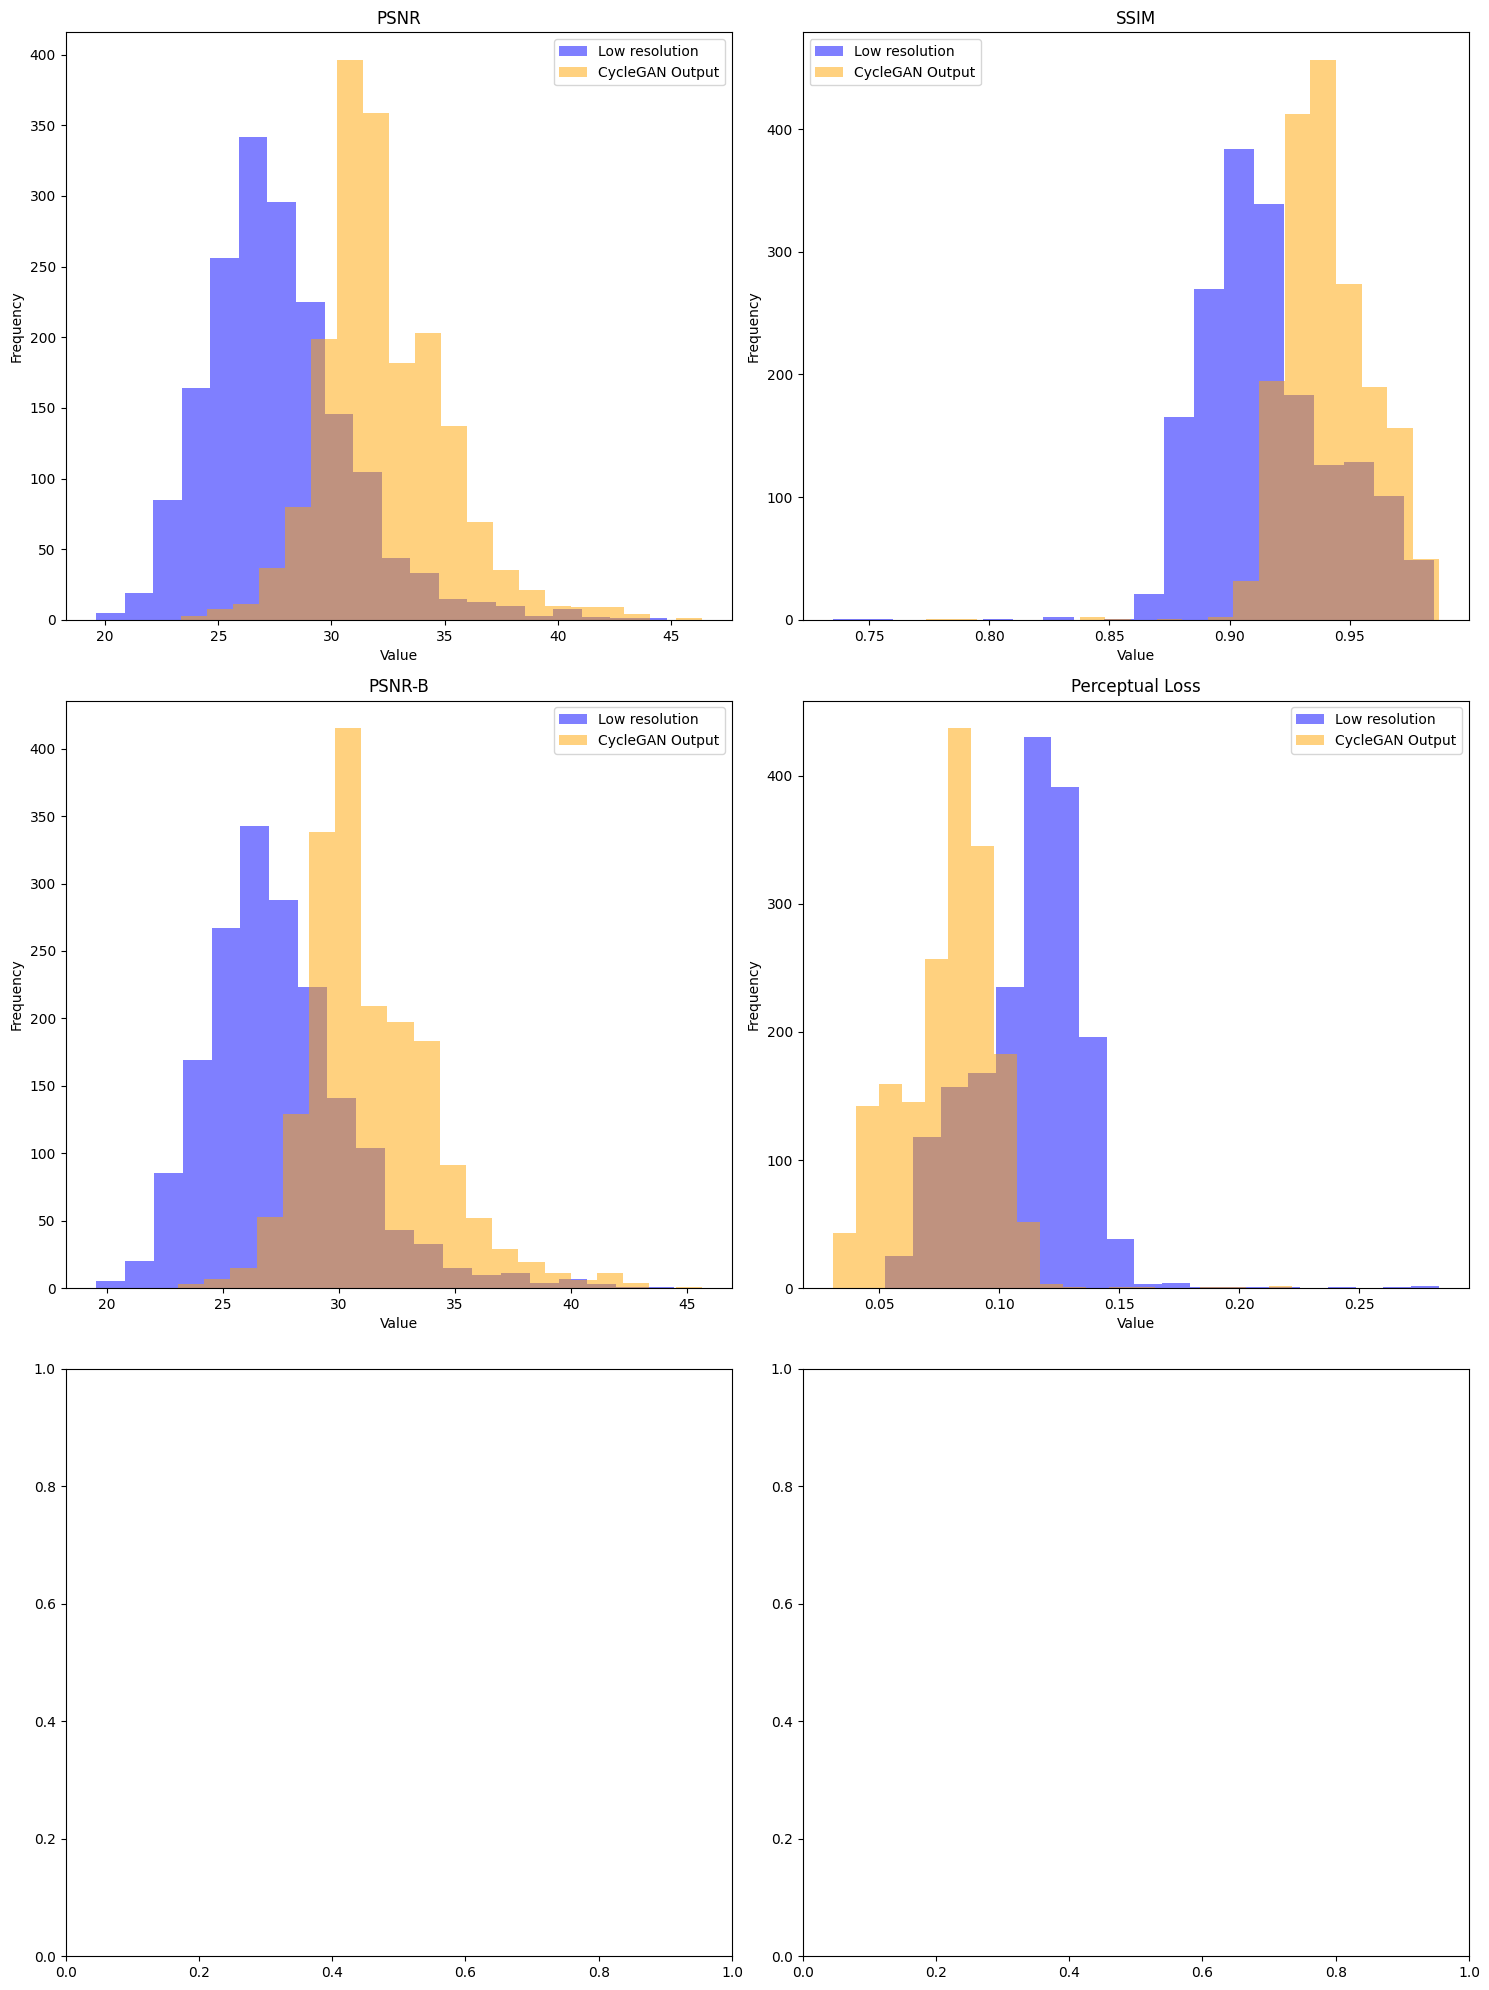

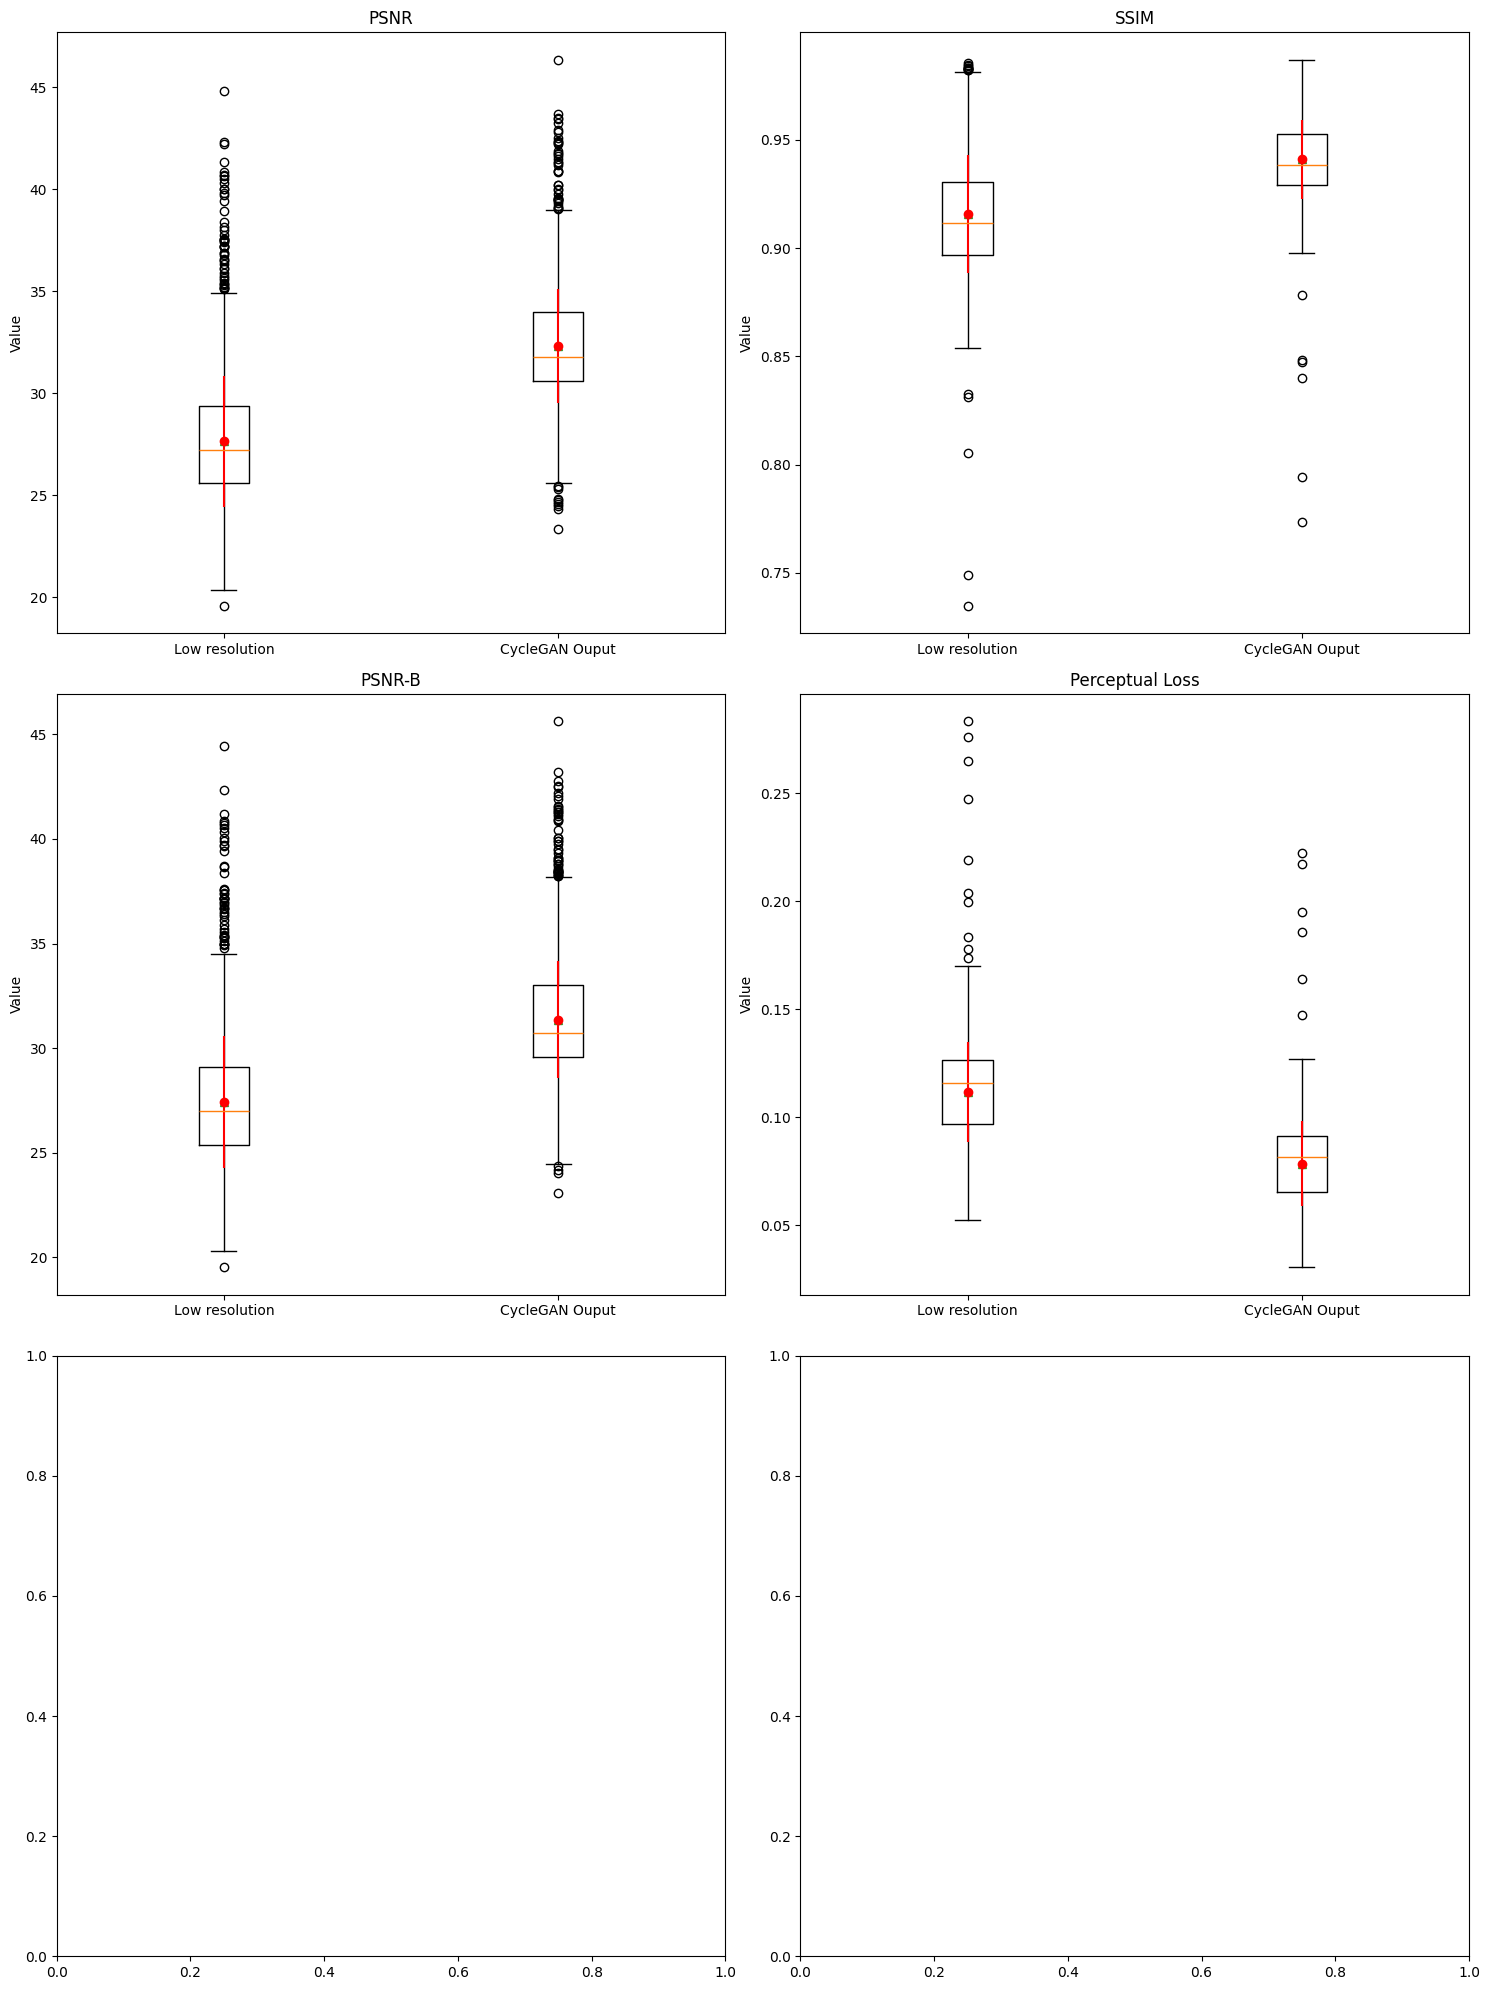

In [14]:
test(G_A2B,val_dataloader)